In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

# Intialize Plots w/ default fig width/height
try
  fig_width = 7
  fig_height = 5
  fig_format = :retina
  fig_dpi = 96
  # no retina format type, use svg for high quality type/marks
  if fig_format == :retina
    fig_format = :svg
  # IJulia doesn't support PDF output so use png (if the DPI 
  # remains the default of 300 then set to 96)
  elseif fig_format == :pdf
    fig_format = :png
    fig_dpi = 96
  end
  # convert inches to pixels
  fig_width = fig_width * fig_dpi
  fig_height = fig_height * fig_dpi
  using Plots
  gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
using VPL

module rbtree
    import VPL
    # Meristem
    struct Meristem <: VPL.Node end
    # Node
    struct Node <: VPL.Node end
    # Internode
    mutable struct Internode <: VPL.Node
        length::Float64
    end
    struct treeparams
        growth::Float64
    end
end

function VPL.feed!(turtle::MTurtle, i::rbtree.Internode)
    HollowCube!(turtle, l = i.length, h =  min(i.length/10, 0.3), w =  min(i.length/10, 0.3), move = true)
    return nothing
end
function VPL.feedcolor!(turtle::GLTurtle, i::rbtree.Internode)
    feedcolor!(turtle, RGB(0,1,0))
    return nothing
end

rule = Rule(rbtree.Meristem, rhs = mer -> rbtree.Node() + 
                                         (RU(-60.0) + rbtree.Internode(0.1) + RH(90.0) + rbtree.Meristem(), 
                                          RU(60.0)  + rbtree.Internode(0.1) + RH(90.0) + rbtree.Meristem()))

Rule replacing nodes of type Main.rbtree.Meristem without context capturing.


In [3]:
function create_tree(origin, growth)
    axiom = T(origin) + rbtree.Internode(0.1) + rbtree.Meristem()
    tree = Graph(axiom, Tuple(rule), rbtree.treeparams(growth))
    return tree
end

create_tree (generic function with 1 method)

In [4]:
getInternode = Query(rbtree.Internode)

function elongate!(tree, query)
    for x in apply(tree, query)
        x.length = x.length*(1.0 + vars(tree).growth)
    end
end

function growth!(tree, query)
    elongate!(tree, query)
    rewrite!(tree)
end

function simulate(tree, query, nsteps)
    new_tree = deepcopy(tree)
    for i in 1:nsteps
        growth!(new_tree, query)
    end
    return new_tree
end

simulate (generic function with 1 method)

In [5]:
origins = [Vec(i,j,0) for i = 1:2.0:20.0, j = 1:2.0:20.0]

10×10 Matrix{StaticArrays.SVector{3, Float64}}:
 [1.0, 1.0, 0.0]   [1.0, 3.0, 0.0]   [1.0, 5.0, 0.0]   …  [1.0, 19.0, 0.0]
 [3.0, 1.0, 0.0]   [3.0, 3.0, 0.0]   [3.0, 5.0, 0.0]      [3.0, 19.0, 0.0]
 [5.0, 1.0, 0.0]   [5.0, 3.0, 0.0]   [5.0, 5.0, 0.0]      [5.0, 19.0, 0.0]
 [7.0, 1.0, 0.0]   [7.0, 3.0, 0.0]   [7.0, 5.0, 0.0]      [7.0, 19.0, 0.0]
 [9.0, 1.0, 0.0]   [9.0, 3.0, 0.0]   [9.0, 5.0, 0.0]      [9.0, 19.0, 0.0]
 [11.0, 1.0, 0.0]  [11.0, 3.0, 0.0]  [11.0, 5.0, 0.0]  …  [11.0, 19.0, 0.0]
 [13.0, 1.0, 0.0]  [13.0, 3.0, 0.0]  [13.0, 5.0, 0.0]     [13.0, 19.0, 0.0]
 [15.0, 1.0, 0.0]  [15.0, 3.0, 0.0]  [15.0, 5.0, 0.0]     [15.0, 19.0, 0.0]
 [17.0, 1.0, 0.0]  [17.0, 3.0, 0.0]  [17.0, 5.0, 0.0]     [17.0, 19.0, 0.0]
 [19.0, 1.0, 0.0]  [19.0, 3.0, 0.0]  [19.0, 5.0, 0.0]     [19.0, 19.0, 0.0]

In [6]:
growth_distr(n) = 0.5 .+ randn(n)./10

growth_distr (generic function with 1 method)

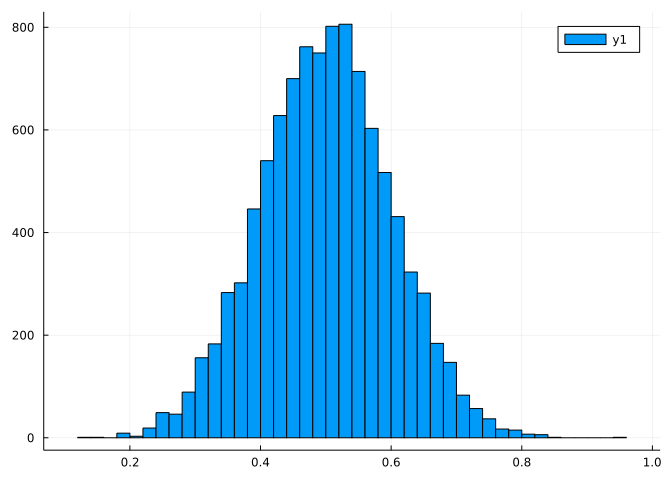

In [7]:
using Plots
histogram(growth_distr(10_000))

In [8]:
growths = growth_distr(100);

In [9]:
forest = [create_tree(origins[i], growths[i]) for i in 1:100];

In [10]:
newforest = [simulate(tree, getInternode, 2) for tree in forest];

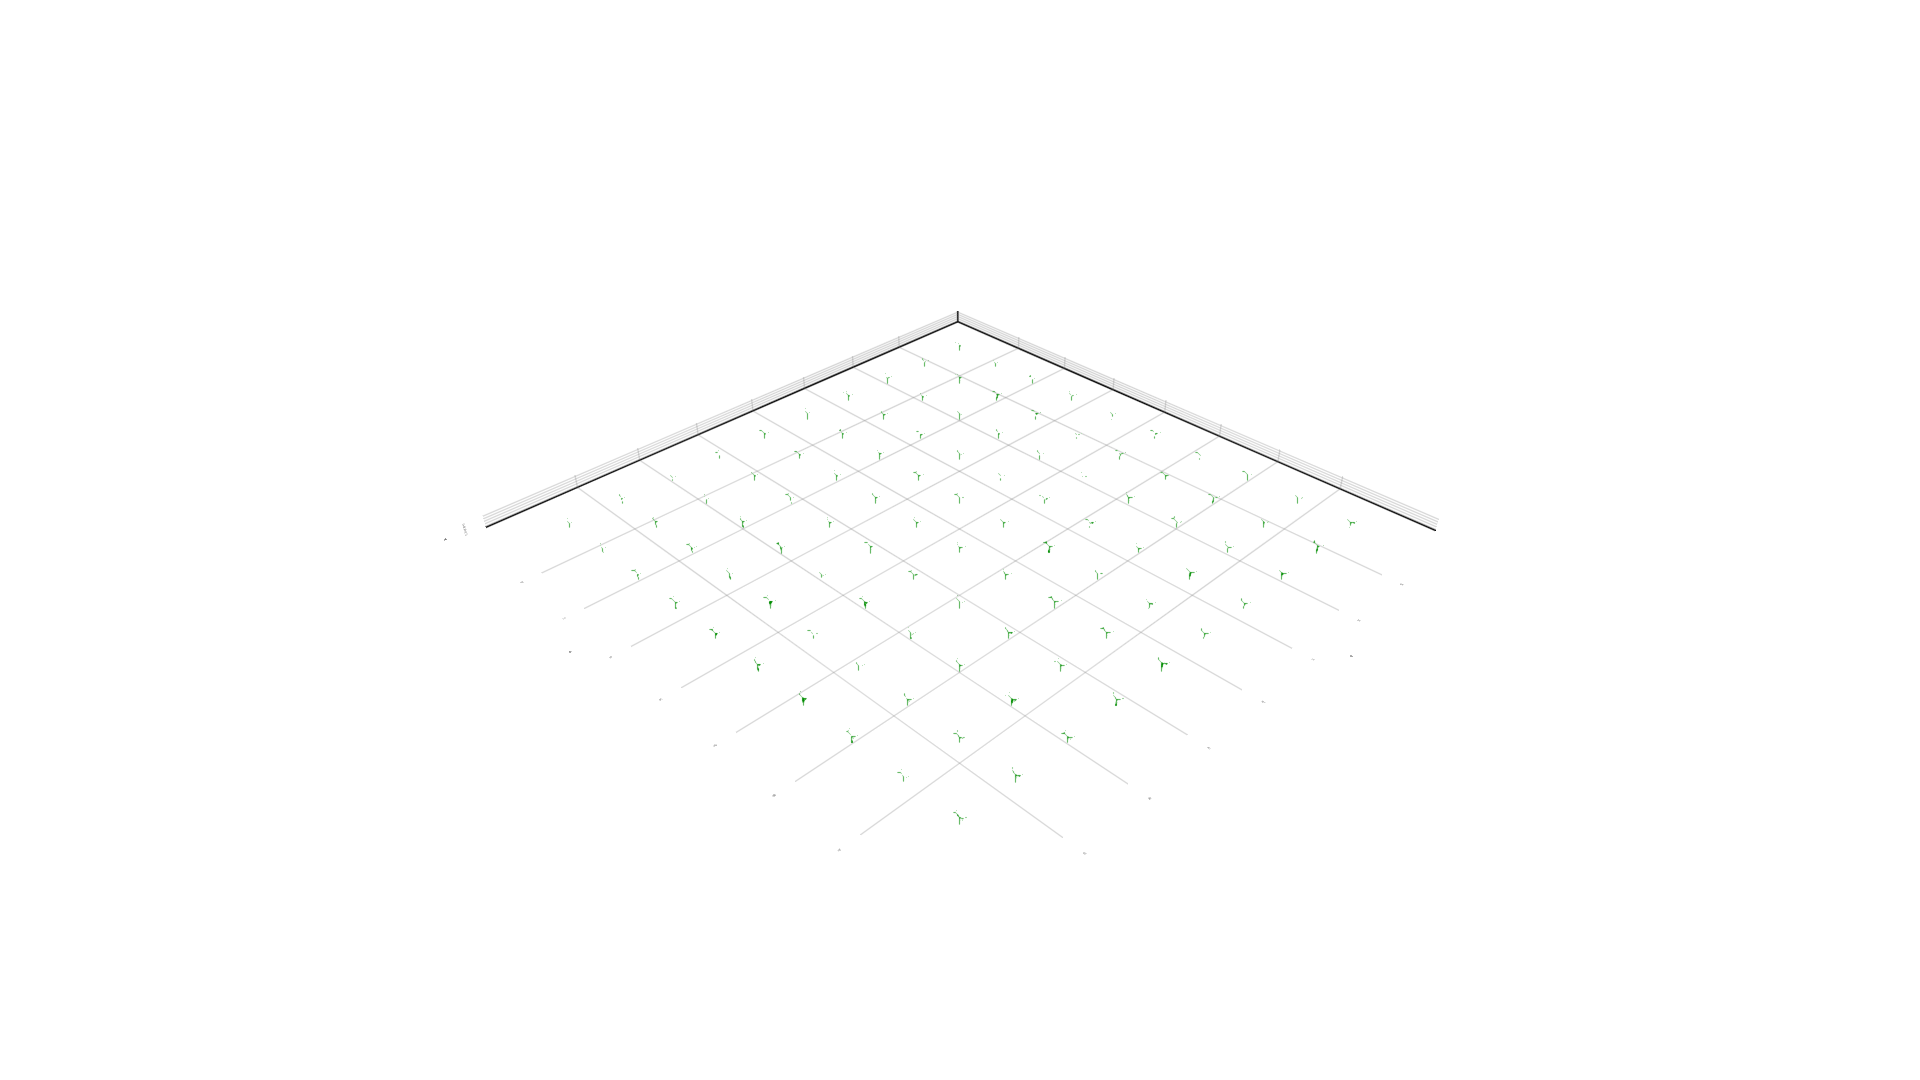

In [11]:
render(newforest)

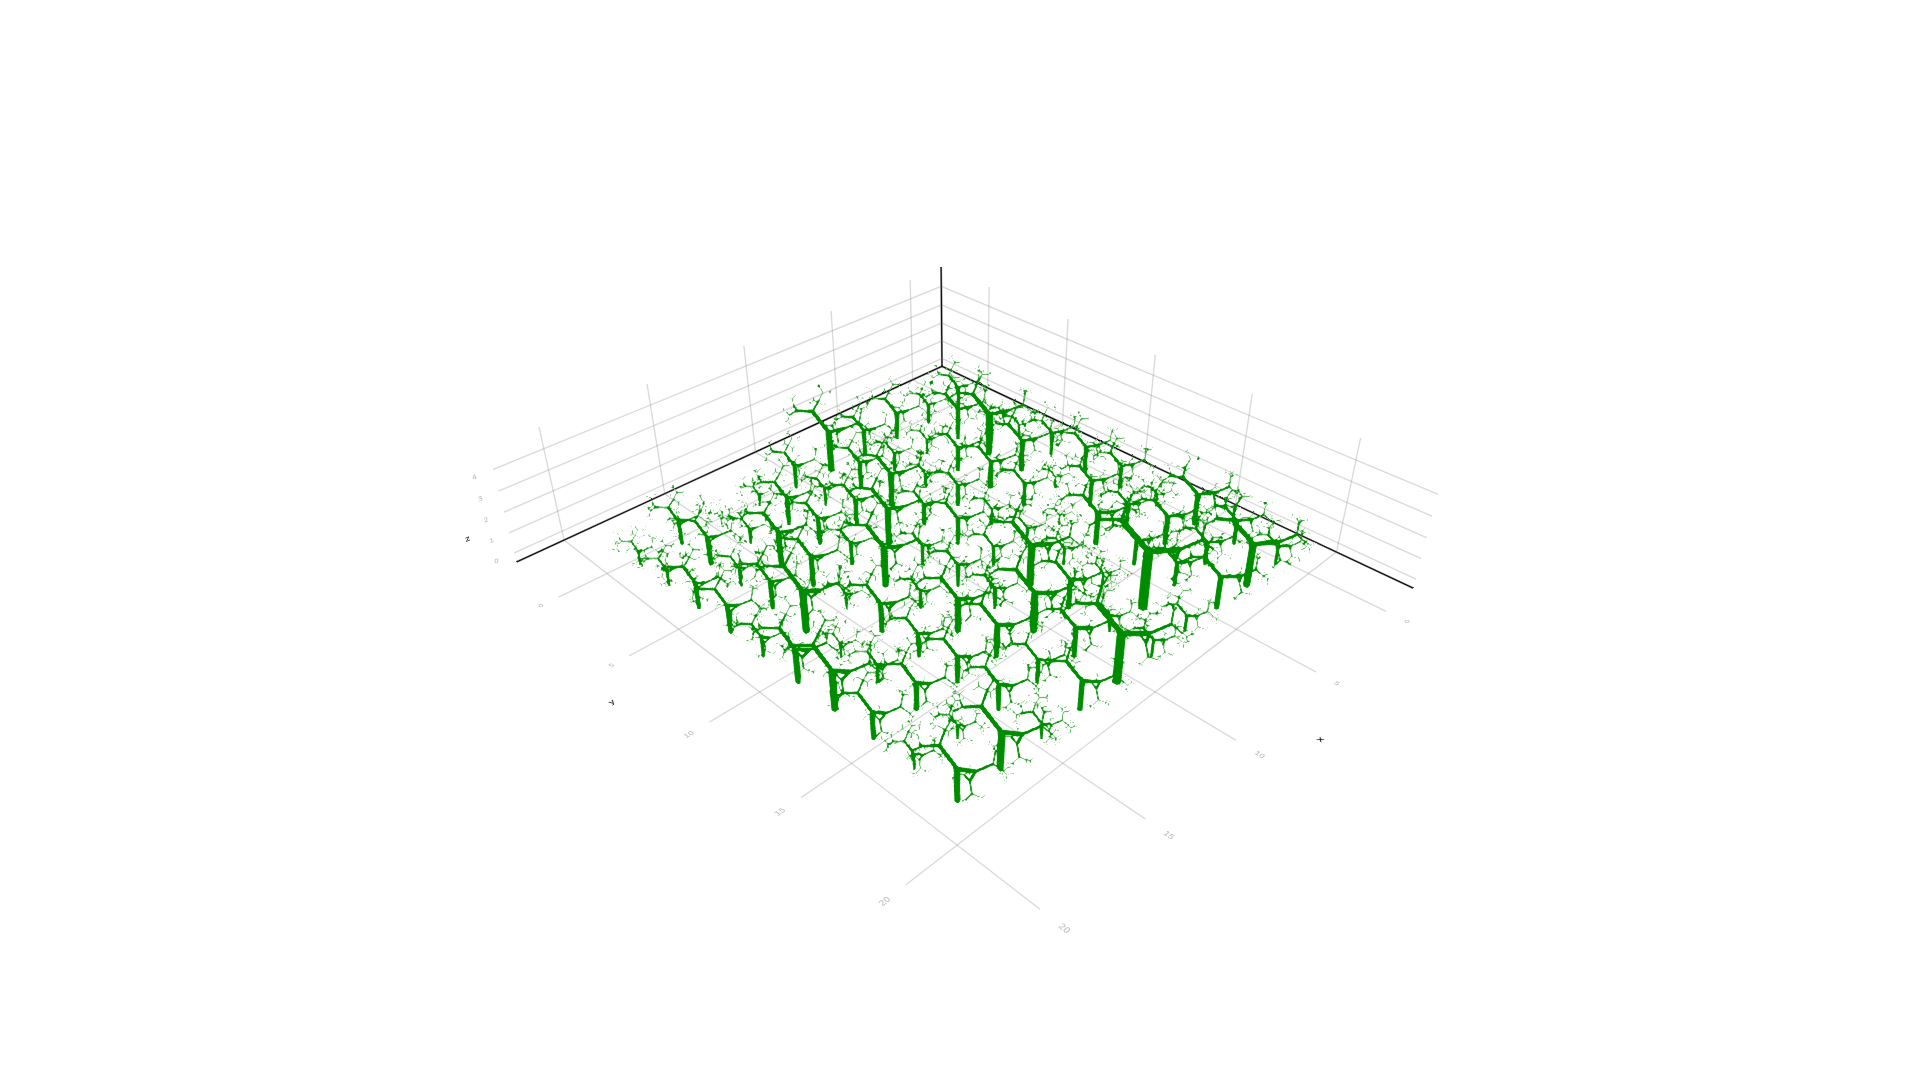

In [12]:
newforest = [simulate(tree, getInternode, 4) for tree in newforest];
render(newforest)

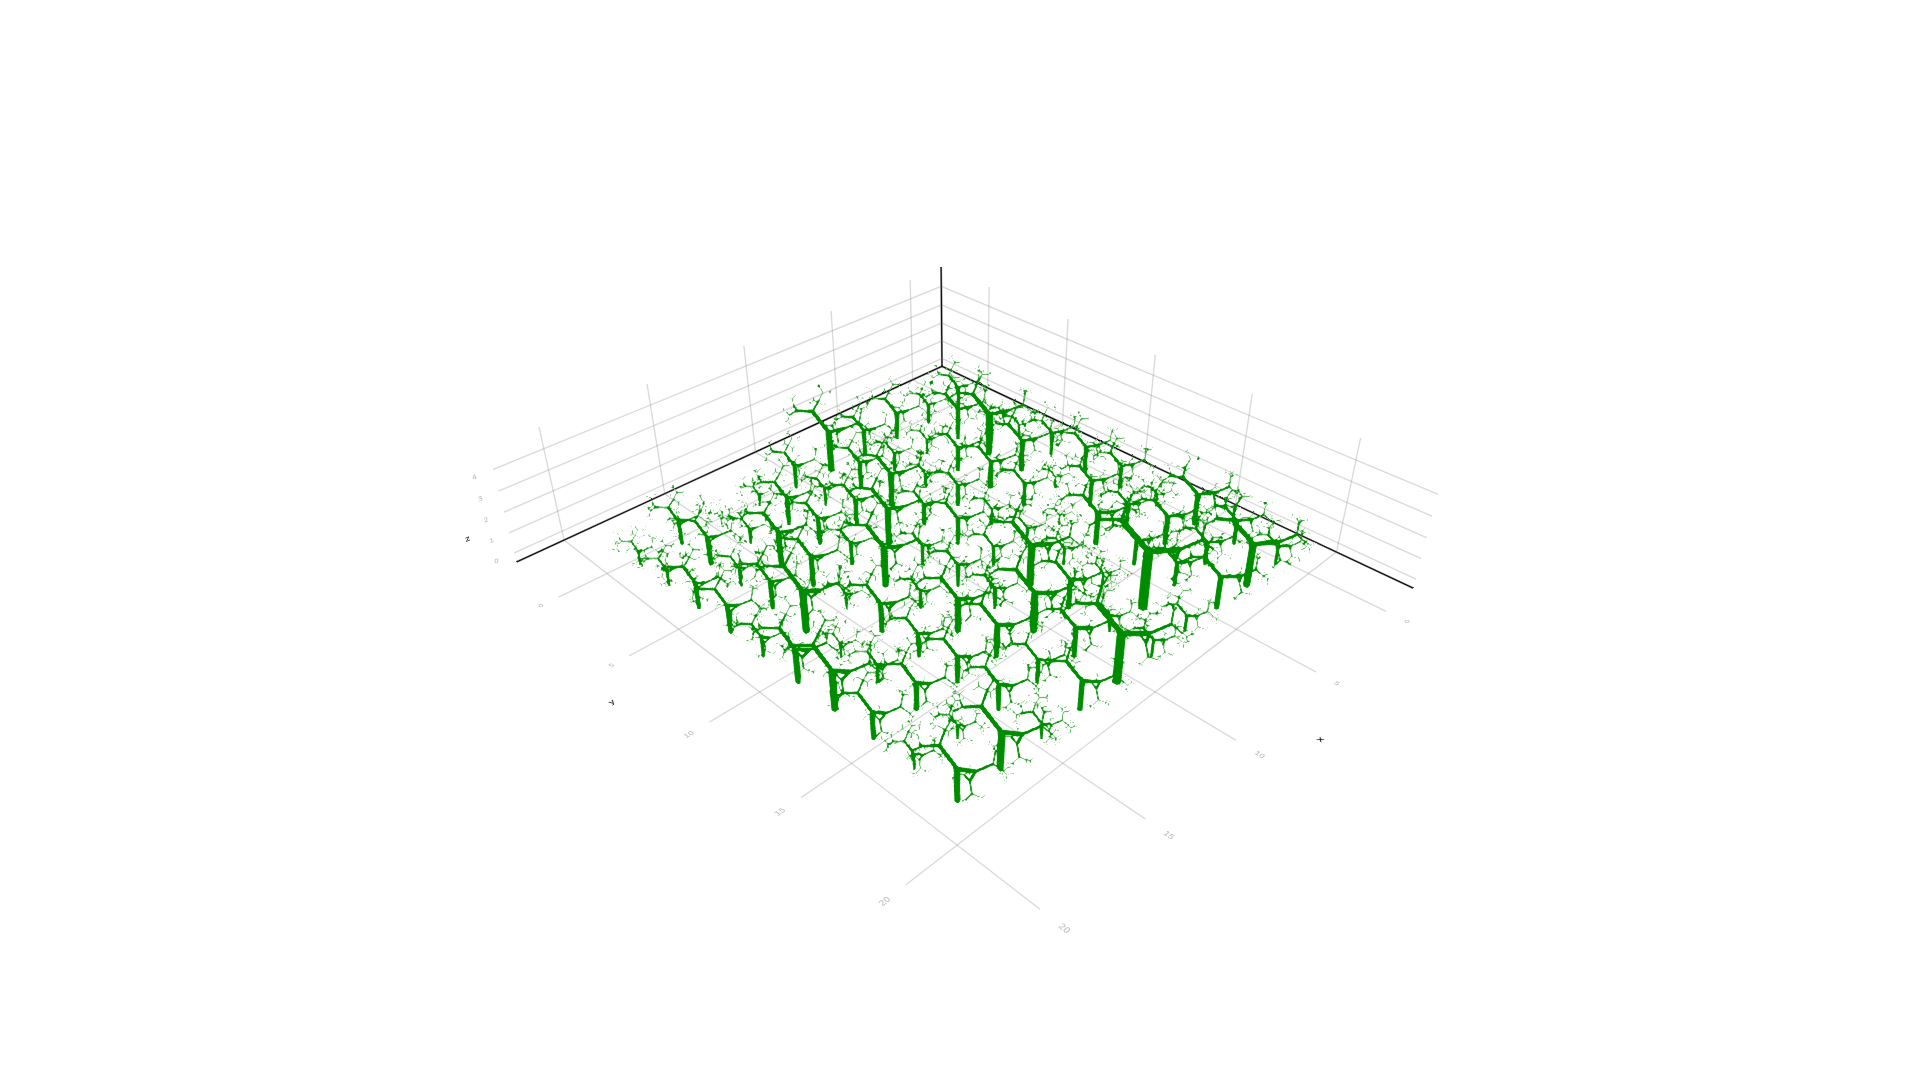

In [13]:
using Base.Threads
newforest = deepcopy(forest)
@threads for i in 1:length(forest)
    newforest[i] = simulate(forest[i], getInternode, 6)
end
render(newforest, parallel = true)

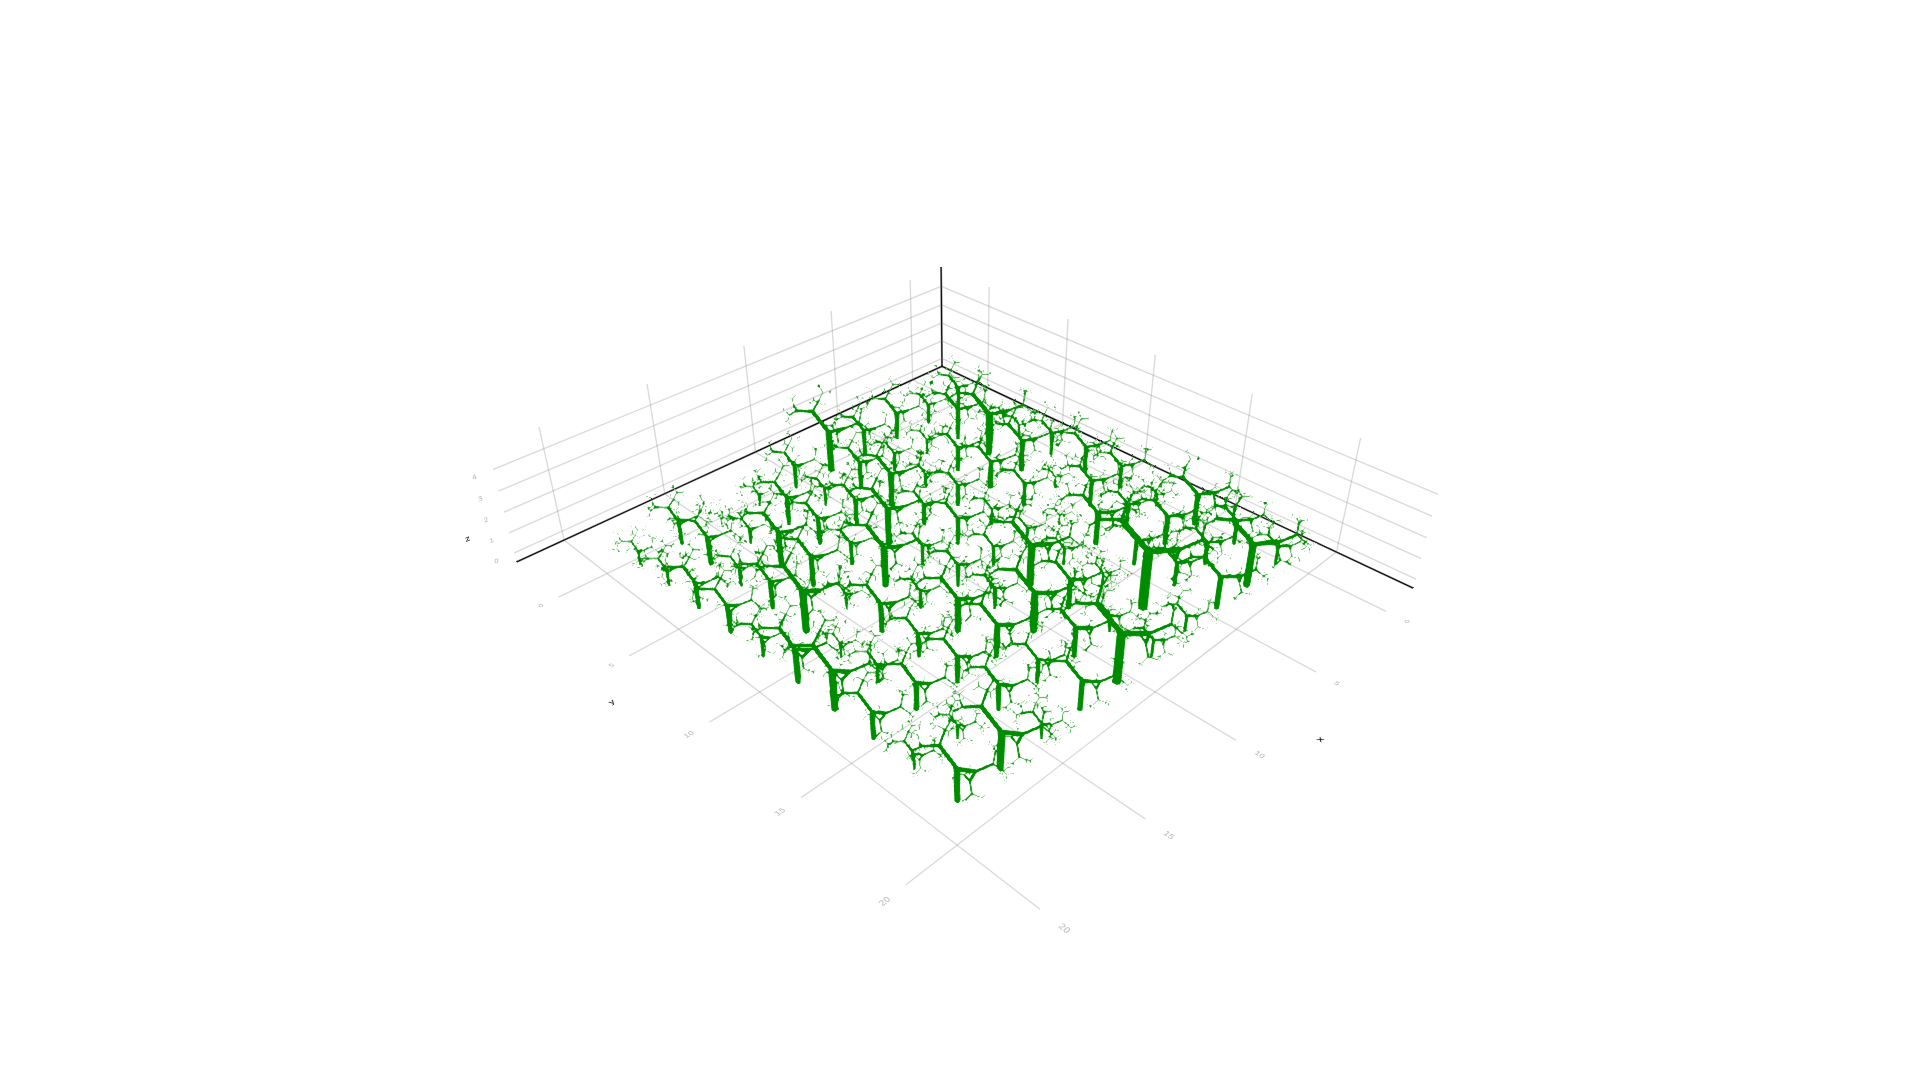

In [14]:
newforest = deepcopy(forest)
for step in 1:6
    @threads for i in 1:length(newforest)
        newforest[i] = simulate(newforest[i], getInternode, 1)
    end
end
render(newforest, parallel = true)

In [15]:
scene = GLScene(newforest);

In [16]:
soil = Rectangle(O(), Y(21.0), X(21.0)); # (corner, side1, side2)

In [17]:
VPL.add!(scene = scene, mesh = soil, color = RGB(1,1,0))

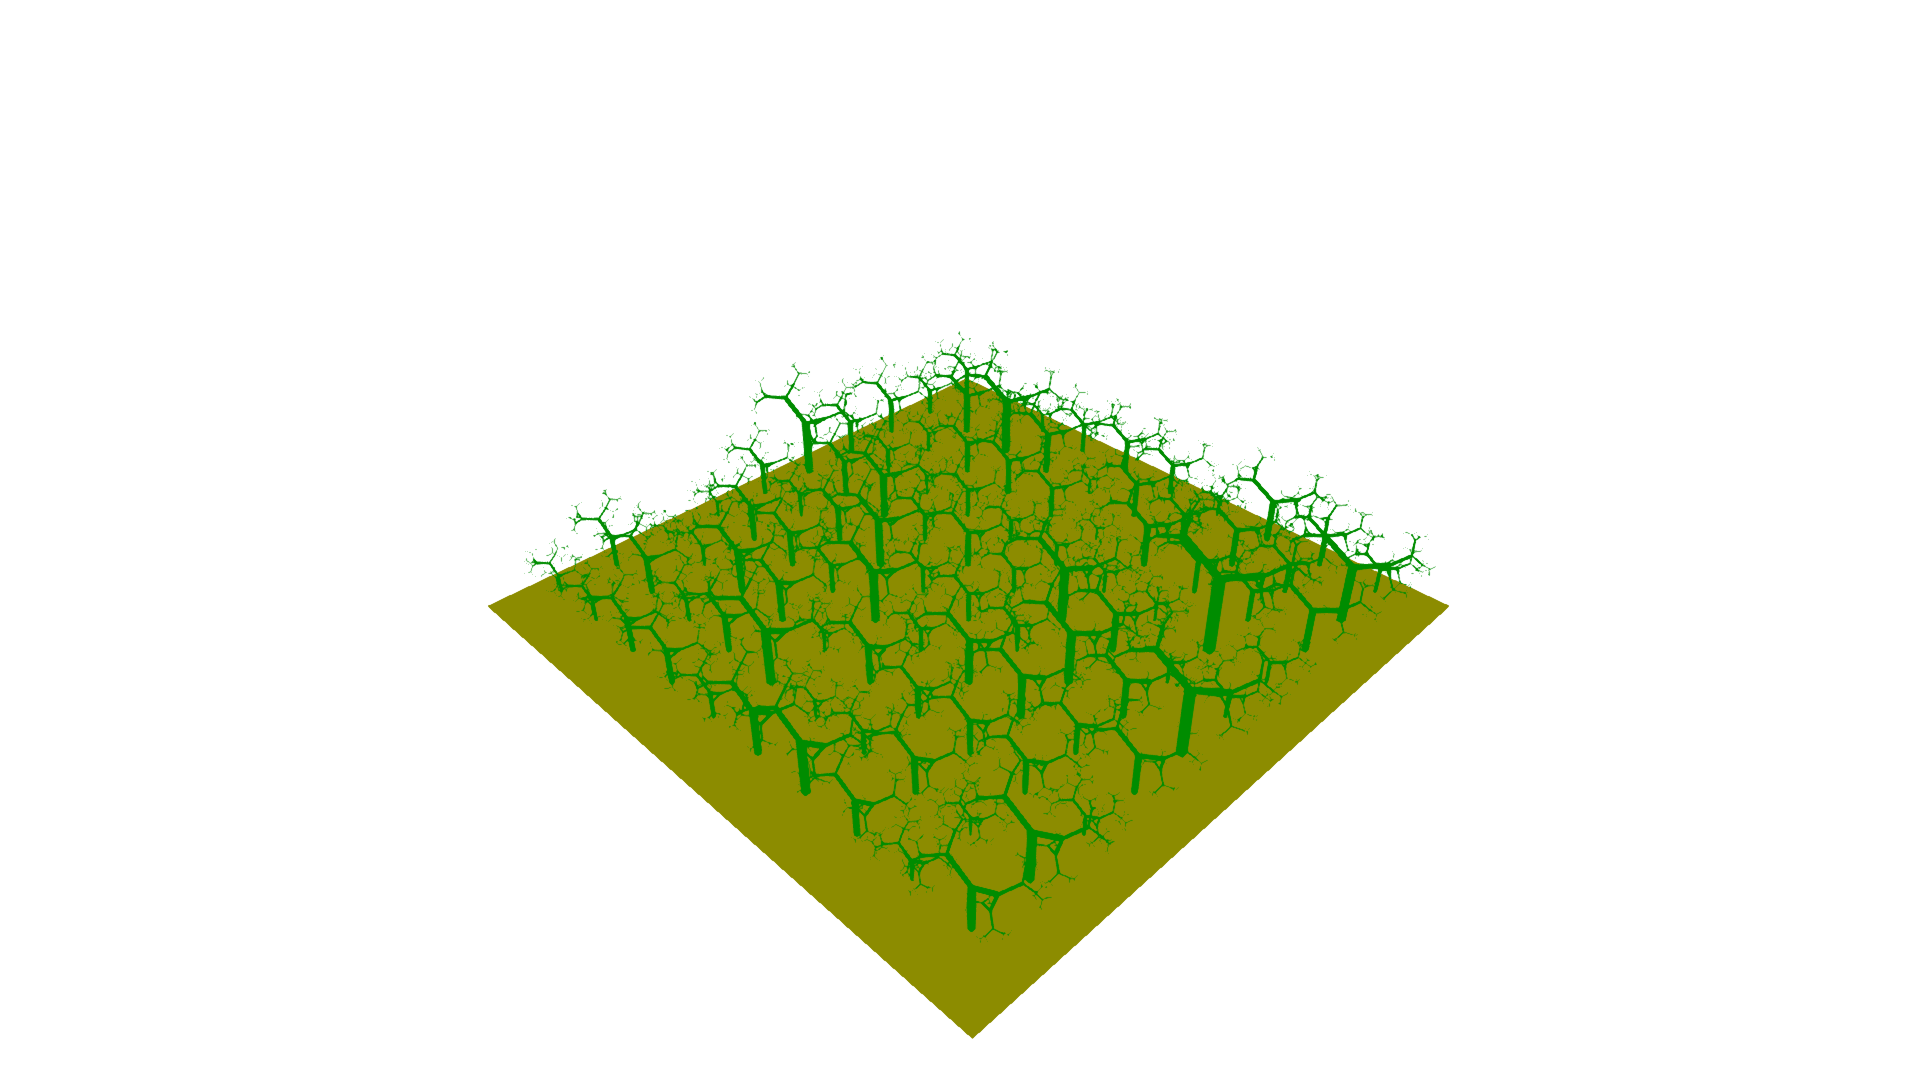

In [18]:
render(scene, show_axis = false)

In [19]:
#| eval: false
gl_win = render(scene, show_axis = false)
# Play around with the scene
save_scene("nice_trees.png", gl_win) 